<a href="https://colab.research.google.com/github/thequiickbrownfox/portfolio/blob/main/Music_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle -q

Reduces the output level. You can use it multiple times to make pip even quieter.



In [8]:
import os
import json
import zipfile
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer  #to convert word into numbers for computer language
from sklearn.metrics.pairwise import cosine_similarity #to find similarity scores for each songs
from wordcloud import WordCloud #to find the words presented in the entire  dataset
import re #to find patterns and match it
import nltk #naturallanguagetoolkit
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize #tokenize lyrics into words

In [4]:
# uploaded= files.upload()

In [5]:
 # dataset= pd.read_csv('spotify_millsongdata.csv')
# dataset

How to deal if you have large datasets

In [10]:
kaggle_config= json.load(open('kaggle.json'))

In [11]:
kaggle_config.keys()

dict_keys(['username', 'key'])

In [12]:
os.environ['KAGGLE_USERNAME']= kaggle_config['username']
os.environ['KAGGLE_KEY']= kaggle_config['key']

In [13]:
#loading the dataset using kaggle api
!kaggle datasets download notshrirang/spotify-million-song-dataset

Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0


In [14]:
!ls

kaggle.json  sample_data  spotify-million-song-dataset.zip


In [15]:
#extracting dataset from zip file
with zipfile.ZipFile('spotify-million-song-dataset.zip','r') as zip_ref:
  zip_ref.extractall()

In [16]:
df= pd.read_csv("/content/spotify_millsongdata.csv")
df

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...
...,...,...,...,...
57645,Ziggy Marley,Good Old Days,/z/ziggy+marley/good+old+days_10198588.html,Irie days come on play \r\nLet the angels fly...
57646,Ziggy Marley,Hand To Mouth,/z/ziggy+marley/hand+to+mouth_20531167.html,Power to the workers \r\nMore power \r\nPowe...
57647,Zwan,Come With Me,/z/zwan/come+with+me_20148981.html,all you need \r\nis something i'll believe \...
57648,Zwan,Desire,/z/zwan/desire_20148986.html,northern star \r\nam i frightened \r\nwhere ...


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [18]:
 top_artists= df['artist'].value_counts().head(10)
 print('\nTop 10 Artists:')
 print(top_artists)


Top 10 Artists:
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Alabama             187
Cher                187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [19]:
df= df.sample(10000) #randomly sample 10k songs from the data
df= df.drop('link', axis=1).reset_index(drop=True)

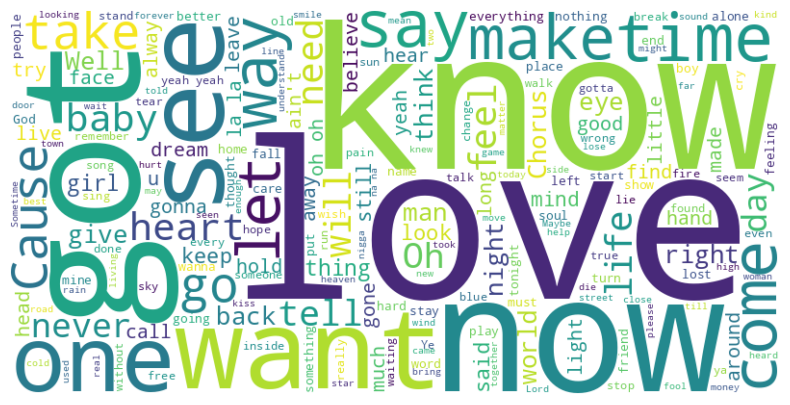

In [20]:
#wordcloud for lyrics of the song
all_lyrics= " ".join(df['text'].dropna())  #take all content of the lyrics and join them into a large one
wordcloud= WordCloud(background_color='white', width=800, height=400).generate(all_lyrics)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Data Preprocessing

In [21]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [22]:
stop_words= set(stopwords.words('english'))

Stop words are common words in a language that are often filtered out before processing text in Natural Language Processing (NLP) tasks because they carry little meaningful information on their own.

Examples of English stop words:
a, an, the, is, in, on, at, of, to, and, but, or, if, because, while, with...

These words are so frequent that they don’t help much in distinguishing one document from another in tasks like:

Text classification

Search engines

Sentiment analysis

In [23]:
#for each word in the text column
def preprocess_text(text):
  text= re.sub(r"[^a-zA-Z\s]", "", text) #remove special characters and numbers
  text= text.lower() #convert to lowercase
  tokens= word_tokenize(text) #tokenise and remove stopwords
  tokens= [word for word in tokens if word not in stop_words]
  return " ".join(tokens)

In [24]:
df['cleaned_text']=df['text'].apply(preprocess_text)

In [25]:
df.head()

,artist,song,text,cleaned_text
0,Ella Fitzgerald,Can't Help Lovin' Dat Man,"Oh listen, sister, \r\nI love my mister man, ...",oh listen sister love mister man cant tell yo ...
1,The Monkees,Mommy And Daddy,"Ask your mommy and daddy, ""What happened to th...",ask mommy daddy happened indian come theyre li...
2,Red Hot Chili Peppers,Soul To Squeeze,I've got a bad disease \r\nBut from my brain ...,ive got bad disease brain bleed insanity seems...
3,Primus,South Park Theme,I'm goin' down to South Park gonna have myself...,im goin south park gon na time friendly faces ...
4,Loretta Lynn,I Can't Hear The Music,He showed me there was more to me \r\nWhen I ...,showed thought nothing else give god knows was...


Converting words into numbers

In [26]:
tfidf_vectorizer= TfidfVectorizer(max_features=5000)
tfidf_matrix= tfidf_vectorizer.fit_transform(df['cleaned_text'])

Cosine similarity matrix

In [27]:
cosine_sim= cosine_similarity(tfidf_matrix, tfidf_matrix)

Recommendation Function

In [28]:
def recommend_songs(song_name, cosine_sim= cosine_sim, df=df, top_n=5):
  song_index= df[df['song'].str.lower()== song_name.lower()].index
  if len(song_index)==0:
    return 'Song not found!'
  song_index= song_index[0]

  sim_scores= list(enumerate(cosine_sim[song_index]))
  sim_scores= sorted(sim_scores, key= lambda x: x[1], reverse=True) #order this based on similarity score; similarity score is the second value
  sim_scores= sim_scores[1:top_n+1] #include everything byt the zeroeth index

  song_indices= [i[0] for i in sim_scores] #getting song indices
  return df['song'].iloc[song_indices]  #return top n similar songs



In [29]:
df['song'][2]

'Soul To Squeeze'

In [34]:
print('\nRecommended Songs:')
recommendations= recommend_songs('Soul To Squeeze')
print(recommendations)


Recommended Songs:
7488    Sing A Little Baby To Sleep
8178                 Feel Good Time
7490          Jesus Is Just Alright
5514                Electric Chapel
7271            Polka Your Eyes Out
Name: song, dtype: object
